## Complementarity & Accessibilty

### 1.  Imports & Declarations

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
# from haversine import haversine as hs
import requests
%matplotlib inline
# from pydantic_settings import BaseSettings
from ydata_profiling import ProfileReport

import sys
sys.path.append('../utils/')
from functions import get_zone_info
from functions import haversine_distance as hsd

In [95]:
##############################################################################################################
# GREEN MOBILITY
##############################################################################################################

# Initialize dataframe
file_path = "../data/processed/gm_raw.csv"
gm_source = pd.read_csv(file_path)

# Rename columns if necessary

# Drop columns if necessary

# Descriptive statistics

# Drop outliers, missing values, etc.

# Add columns if necessary

#################################################################################################################
# DRIVE NOW
#################################################################################################################

# 1. Initialize dataframe
file_path = "../data/raw/DriveNow/DTU - data til case_LTMZones1.csv"
sn_source = pd.read_csv(file_path, sep=";")

# 2. Rename columns if necessary
sn_source.rename(columns= {
                            "Latitude (Start)": "LatitudeStart", 
                            "Longitude (Start)": "LongitudeStart", 
                            'Latitude (Slut)': "LatitudeEnd", 
                            'Longitude (Slut)':'LongitudeEnd',
                            'Reservationstidspunkt': "ReservationTime",
                            'Start tidspunkt': "StartTime",
                            'Slut tidspunkt': "EndTime",
                            'Alder': "Age",
                            'Køn': "Gender",
                            'Batteristatus (start)': "BatteryStart",
                            'Batteristatus (slut)':"BatteryEnd",
                            'Km kørt': "KmDriven"
                            }, inplace=True)

# 3. Drop columns if necessary
sn_source.drop(columns=['TurID'],inplace=True)

# 4. Convert to appropriate data types
# Convert to Numeric the following columns:
coordinates = [
    'LatitudeEnd',
    'LatitudeStart',
    'LongitudeEnd',
    'LongitudeStart'
]

for col in coordinates:
    sn_source[col] = sn_source[col].apply(lambda x: x.replace(',','.'))
    sn_source[col] = pd.to_numeric(sn_source[col],errors='coerce')

target_ls = [
    'KmDriven',
    'BatteryStart',
    'BatteryEnd',
]
for col in target_ls:
    sn_source[col] = pd.to_numeric(sn_source[col],errors='coerce')

sn_source['EndTime'] = pd.to_datetime(sn_source['EndTime'], errors='coerce')    #   to DateTime
sn_source['StartTime'] = pd.to_datetime(sn_source['StartTime'], errors='coerce')    #   to Datetime


# 5. Auxiliary columns
sn_source['TripDurationHours'] = (sn_source['EndTime'] - sn_source['StartTime']).dt.total_seconds()/3600
sn_source['TripDurationMinutes'] = sn_source['TripDurationHours']*60  #   trip duration in min
sn_source['AvgSpeed'] = sn_source['KmDriven']/sn_source['TripDurationHours'] #   avg speed

sn_source['Month'] = sn_source['StartTime'].dt.strftime("%B").astype('category')  #   month
sn_source['Weekday'] = sn_source['StartTime'].dt.day_name().astype('category')    #   day of the week
sn_source['StartHour'] = sn_source['StartTime'].dt.hour.astype('category')    #   hour of the day

# 6. Descriptive statistics
sn_source.describe()

# 7. Drop outliers, missing values, etc.

# drop rows with missing values
sn_source.dropna(inplace=True)

# drop rows with BatteryEnd less than BatteryStart
sn_source = sn_source[sn_source['BatteryStart'] >= sn_source['BatteryEnd']]

# drop rows with coordinates equal to 0 
for col in coordinates:
    sn_source = sn_source[(sn_source[col] != 0)|(sn_source[col] != '')]


# replace negative BatteryEnd with 0
sn_source['BatteryEnd'] = sn_source['BatteryEnd'].apply(lambda x: 0 if x < 0 else x)

# # drop rows with negative and avg speed > 100 km/h
sn_source = sn_source[(sn_source['AvgSpeed'] > 1) & (sn_source['AvgSpeed'] < 100)]


# # 8. Add columns if necessary
# # Add haversise distance to the dataframe
sn_source['HaversineDistance'] = hsd(sn_source['LatitudeStart'], sn_source['LongitudeStart'],sn_source['LatitudeEnd'], sn_source['LongitudeEnd'])
sn_source['HaversineDistance'] = sn_source['HaversineDistance'].apply(lambda x: round(x,0))

# # drop rows with Haversine distance > 1000 km
sn_source = sn_source[sn_source['HaversineDistance'] < 1000]

##################################################################################################################
# DONKEY REPUBLIC
##################################################################################################################


# Initialize Donkey Republic dataframe
# file_path = ""
# donkey_source = ""

# Rename columns if necessary

# Drop columns if necessary

# Descriptive statistics

# Drop outliers, missing values, etc.



/var/folders/77/lfxftc1s7_bch_43_w38l1zh0000gn/T/ipykernel_56910/1435310979.py:25: DtypeWarning: Columns (12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  sn_source = pd.read_csv(file_path, sep=";")
/var/folders/77/lfxftc1s7_bch_43_w38l1zh0000gn/T/ipykernel_56910/1435310979.py:67: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  sn_source['EndTime'] = pd.to_datetime(sn_source['EndTime'], errors='coerce')    #   to DateTime
/var/folders/77/lfxftc1s7_bch_43_w38l1zh0000gn/T/ipykernel_56910/1435310979.py:68: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  sn_source['StartTime'] = pd.to_datetime(sn_source['StartTime'], errors='coerce')    #   to Datetime


## TEST RESULTS

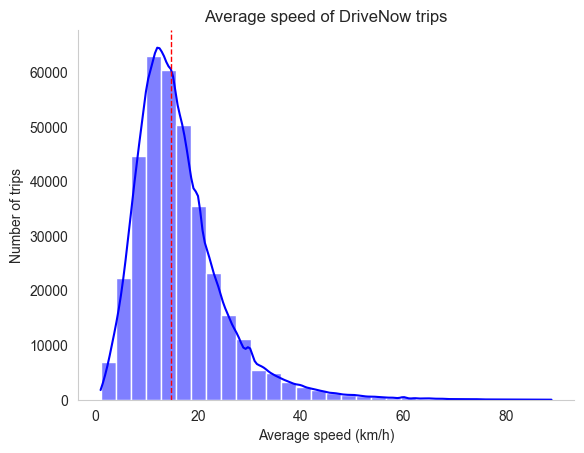

In [77]:
# plot histogram of average speed between 0 and 90 km/h using seaborn 
sns.histplot(data=sn_source[(sn_source['AvgSpeed']>0) & (sn_source['AvgSpeed']<90)], x="AvgSpeed", bins=30, color='blue', kde=True)
# change color of histogram
sns.set_palette('Blues_r')
sns.set_style('whitegrid')

sns.despine()

# add title and labels
plt.title("Average speed of DriveNow trips")
plt.xlabel("Average speed (km/h)")
plt.ylabel("Number of trips")
plt.grid(False)
# plt.show()

# show median on the plot
plt.axvline(x=sn_source['AvgSpeed'].median(), color='red', linestyle='--', linewidth=1)
plt.show()

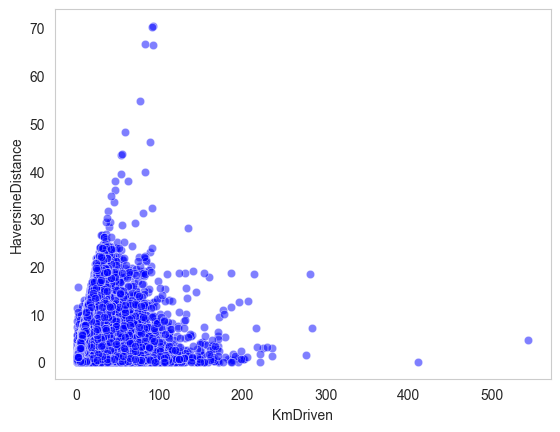

In [78]:
# scatter plot of kmdriven vs haversine distance
sns.scatterplot(data=sn_source, x="KmDriven", y="HaversineDistance", color='blue', alpha=0.5)
# change color of histogram
sns.set_palette('Blues_r')
sns.set_style('whitegrid')
plt.grid(False)
plt.show()

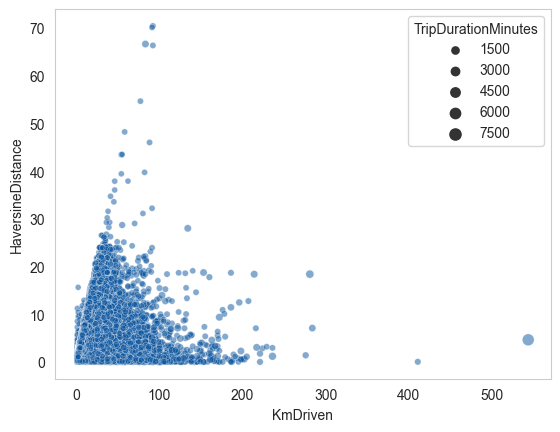

In [83]:
# bubble chart of kmdriven vs haversine distance with tripduration as bubble size
sns.scatterplot(data=sn_source, x="KmDriven", y="HaversineDistance", size="TripDurationMinutes", alpha=0.5)
# change color of histogram
sns.set_palette('Blues_r')
sns.set_style('whitegrid')
plt.grid(False)
plt.show()

### 2.  Trips profiling and statistics

#### 2.1 GreenMobility Dataset

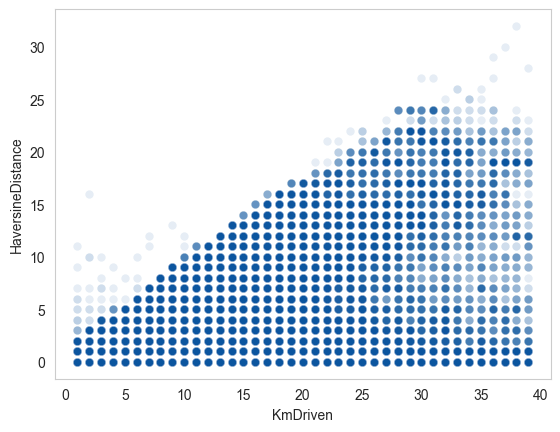

In [97]:

sns.scatterplot(data=sn_source[sn_source['KmDriven'] < 40], x="KmDriven", y="HaversineDistance", alpha=0.1)
# change color of histogram
sns.set_palette('Blues_r')
sns.set_style('whitegrid')
plt.grid(False)
plt.show()

In [94]:
sn_source.head(20)

,BilID,PersonID,LatitudeStart,LongitudeStart,LatitudeEnd,LongitudeEnd,ReservationTime,StartTime,EndTime,Age,...,KmDriven,FromZoneID,ToZoneID,TripDurationHours,TripDurationMinutes,AvgSpeed,Month,Weekday,StartHour,HaversineDistance
0,WBY1Z21040V307905,32614,55.670268,12.586064,55.652954,12.544699,16/08/2017 14:40,2017-08-16 14:34:00,2017-08-16 14:52:00,32,...,5,103142,102851,0.300000,18.0,16.666667,August,Wednesday,14,3.231816
1,WBY1Z21040V308214,44363,55.687024,12.585952,55.726655,12.553914,16/08/2017 14:42,2017-08-16 14:38:00,2017-08-16 15:05:00,25,...,7,102212,157231,0.450000,27.0,15.555556,August,Wednesday,14,4.843874
3,WBY1Z21040V307869,37425,55.630274,12.648864,55.706866,12.587122,31/07/2017 20:31,2017-07-31 20:31:00,2017-08-01 09:13:00,30,...,18,185203,102341,12.700000,762.0,1.417323,July,Monday,20,9.358422
5,WBY1Z21090V308015,18497,55.700745,12.473436,55.630263,12.648955,31/07/2017 21:11,2017-07-31 21:04:00,2017-08-01 04:28:00,42,...,28,102651,185203,7.400000,444.0,3.783784,July,Monday,21,13.517087
6,WBY1Z21070V308188,43226,55.680014,12.507755,55.692454,12.504951,31/07/2017 21:26,2017-07-31 21:25:00,2017-08-01 00:01:00,25,...,109,147234,102621,2.600000,156.0,41.923077,July,Monday,21,1.394825
7,WBY1Z21060V308019,28029,55.712655,12.561513,55.658484,12.536456,31/07/2017 21:57,2017-07-31 21:56:00,2017-08-01 00:04:00,26,...,7,102412,102841,2.133333,128.0,3.281250,July,Monday,21,6.226910
8,WBY1Z21020V307966,36757,55.698884,12.527443,55.630211,12.648979,31/07/2017 22:11,2017-07-31 22:05:00,2017-08-01 06:39:00,33,...,17,102542,185203,8.566667,514.0,1.984436,July,Monday,22,10.792842
10,WBY1Z21050V308061,44704,55.639379,12.608151,55.645413,12.636450,31/07/2017 22:32,2017-07-31 22:18:00,2017-08-01 01:24:00,21,...,81,103252,103211,3.100000,186.0,26.129032,July,Monday,22,1.898980
11,WBY1Z21020V307904,37605,55.723002,12.531367,55.676452,12.598821,31/07/2017 23:10,2017-07-31 23:09:00,2017-08-01 00:17:00,30,...,14,102522,103141,1.133333,68.0,12.352941,July,Monday,23,6.684756
12,WBY1Z21020V308146,43376,55.665441,12.557626,55.698740,12.457109,31/07/2017 23:36,2017-07-31 23:18:00,2017-08-01 00:03:00,21,...,13,102812,175043,0.750000,45.0,17.333333,July,Monday,23,7.311024


/var/folders/77/lfxftc1s7_bch_43_w38l1zh0000gn/T/ipykernel_88003/1427624344.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(gm_data['HaversineDistance'], bins=100, color='blue', palette='Blues_r', kde=True)


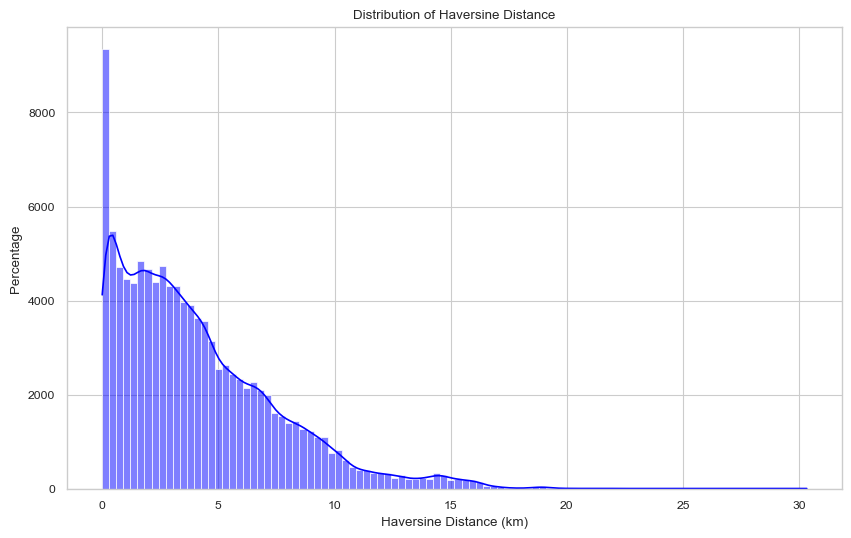

In [ ]:
# distribution of haversine distance visuzaliations
plt.figure(figsize=(10,6))
sns.set_style('whitegrid')
sns.set_palette('Blues_r')
sns.despine()
sns.histplot(gm_data['HaversineDistance'], bins=100, color='blue', palette='Blues_r', kde=True)
plt.ylabel('Percentage')
# plt.yticks(np.arange(0, 0.06, 0.01))
# plt.gca().yaxis.set_major_formatter('{:.0f}%'.format)
plt.xlabel('Haversine Distance (km)')
plt.title('Distribution of Haversine Distance')
# plt.savefig('../reports/figures/haversine_distance.png')
plt.show()

In [ ]:
# Generate the profile report
profile = ProfileReport(sn_source, title='Pandas Profiling Report', explorative=True)

# Or to view it in a Jupyter Notebook
profile.to_notebook_iframe()


In [90]:
sn_source[['LatitudeEnd','LatitudeStart','LongitudeEnd','LongitudeStart']]

,LatitudeEnd,LatitudeStart,LongitudeEnd,LongitudeStart
2,"55,775655","55,692382","12,513962","12,583143"
3,"55,706866","55,630274","12,587122","12,648864"
4,"55,677484","55,693602","12,489247","12,53821"
5,"55,630263","55,700745","12,648955","12,473436"
6,"55,692454","55,680014","12,504951","12,507755"
...,...,...,...,...
365424,"55,665031","55,668776","12,516615","12,516638"
365442,"55,656599","55,665624","12,487849","12,483596"
365448,"55,671479","55,676891","12,533911","12,538845"
365464,"55,671468","55,672062","12,534098","12,495884"


## STATISTICAL ANALYSIS : Hypothesis testing